In [1]:
import tensorflow as tf
from tensorflow.python.ops.rnn import _transpose_batch_time
import numpy as np

from helpers import get_sequences, iterate_minibatches, get_minibatches

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\sshi\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### First create a simple train and test set

In [2]:
# create a sine wave
n_samples = int(1e3)
min_x = 0
max_x = 100
x = np.linspace(min_x, max_x, n_samples)
sinx = np.sin(x)
# add a Gaussian noise to it
noise_m = 1
noise_sd = 0.5
noise = np.random.normal(noise_m, noise_sd, n_samples)
smooth = sinx+noise_m
y = sinx + noise

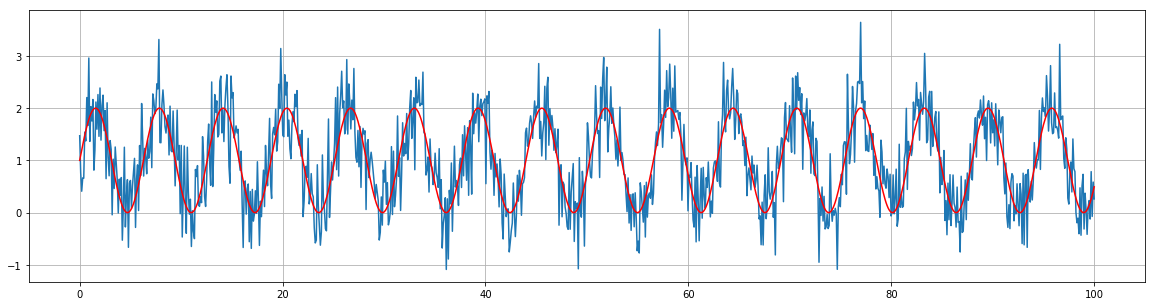

In [3]:
# plot
plt.figure(figsize=(20,5))
plt.plot(x, y, x, sinx+noise_m, 'r')
plt.grid(True)

In [4]:
# split it to train and test
slice_ind = int(n_samples*0.7)
# clear up namings for modeling
plot_train_x, train_x, plot_test_x, test_x, smooth_train_x, smooth_test_x = [x[:slice_ind], y[:slice_ind], 
                                                                             x[slice_ind:], y[slice_ind:], 
                                                                             smooth[:slice_ind], smooth[slice_ind:]]


# train_x, train_y, test_x, test_y, smooth_y_train, smooth_y_test = x[:slice_ind], y[:slice_ind], x[slice_ind:], y[slice_ind:], smooth[:slice_ind], smooth[slice_ind:]
# train_n, test_n = len(train_x), len(test_x)

# chunk it to each small window
seq_len = 5
train_x = get_sequences(train_x, seq_len, 1)

In [5]:
train_x.shape

(140, 5, 1)

In [6]:
test_x.shape

(300,)

#### So we observe the drift from lstm if it were to generate actual predictions
we employ a different training scheme 

In [7]:
def sampling_rnn(cell, initial_state, input_, seq_lengths):    
    # raw_rnn expects time major inputs as TensorArrays
    max_time = seq_len  # this is the max time step per batch
    inputs_ta = tf.TensorArray(dtype=tf.float32, size=max_time, clear_after_read=False)
    inputs_ta = inputs_ta.unstack(_transpose_batch_time(input_))  # model_input is the input placeholder
    input_dim = input_.get_shape()[-1].value  # the dimensionality of the input to each time step
    output_dim = 1  # the dimensionality of the model's output at each time step

    def loop_fn(time, cell_output, cell_state, loop_state):
        """
        Loop function that allows to control input to the rnn cell and manipulate cell outputs.
        :param time: current time step
        :param cell_output: output from previous time step or None if time == 0
        :param cell_state: cell state from previous time step
        :param loop_state: custom loop state to share information between different iterations of this loop fn
        :return: tuple consisting of
          elements_finished: tensor of size [bach_size] which is True for sequences that have reached their end,
            needed because of variable sequence size
          next_input: input to next time step
          next_cell_state: cell state forwarded to next time step
          emit_output: The first return argument of raw_rnn. This is not necessarily the output of the RNN cell,
            but could e.g. be the output of a dense layer attached to the rnn layer.
          next_loop_state: loop state forwarded to the next time step
        """
        if cell_output is None:
            # time == 0, used for initialization before first call to cell
            next_cell_state = initial_state
            # the emit_output in this case tells TF how future emits look
            emit_output = tf.zeros([output_dim])
        else:
            # t > 0, called right after call to cell, i.e. cell_output is the output from time t-1.
            # here you can do whatever ou want with cell_output before assigning it to emit_output.
            # In this case, we don't do anything
            next_cell_state = cell_state
#             emit_output = cell_output 
            
            emit_output = tf.contrib.layers.fully_connected(inputs=cell_output, num_outputs=output_dim)
        
        # check which elements are finished
        elements_finished = (time >= seq_lengths)
        finished = tf.reduce_all(elements_finished)

        # assemble cell input for upcoming time step
        current_output = emit_output if cell_output is not None else None
        input_original = inputs_ta.read(time)  # tensor of shape (None, input_dim)
        if current_output is None:
            # this is the initial step, i.e. there is no output from a previous time step, what we feed here
            # can highly depend on the data. In this case we just assign the actual input in the first time step.
            next_in = input_original
        else:
            # time > 0, so just use previous output as next input
            # here you could do fancier things, whatever you want to do before passing the data into the rnn cell
            # if here you were to pass input_original than you would get the normal behaviour of dynamic_rnn
            next_in = current_output

        next_input = tf.cond(finished,
                             lambda: tf.zeros([batch_size, input_dim], dtype=tf.float32),  # copy through zeros
                             lambda: next_in)  # if not finished, feed the previous output as next input
        # set shape manually, otherwise it is not defined for the last dimensions
        next_input.set_shape([None, input_dim])

        # loop state not used in this example
        next_loop_state = None
        return (elements_finished, next_input, next_cell_state, emit_output, next_loop_state)
    outputs_ta, last_state, _ = tf.nn.raw_rnn(cell, loop_fn)
    outputs = _transpose_batch_time(outputs_ta.stack())
    final_state = last_state

    return outputs, final_state


In [8]:
%%time
tf.reset_default_graph()

batch_size = 32
# n_batches = train_x.shape[0]//batch_size
state_size = 100


# cell
lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(state_size, forget_bias=1.)
# initial state
initial_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)



# inputs = tf.placeholder(shape=(max_time, batch_size, input_depth),
#                         dtype=tf.float32)

# input 
X = tf.placeholder(tf.float32, [batch_size, seq_len, 1])#, name = 'input')
Y = tf.placeholder(tf.float32, [batch_size, seq_len, 1])#, name = 'output')

output, last_states = sampling_rnn(cell=lstm_cell, 
                                   initial_state=initial_state, 
                                   input_=X,
                                   seq_lengths=seq_len)
# output as the prediction
pred = tf.reshape(output, (batch_size, seq_len, 1))
# loss
# shift to create next time step
# label = tf.manip.roll(Y, 1, axis=0)
print('label shape:{0:} | output prediction shape: {1:}'.format(Y.shape, pred.shape))
# loss
loss = tf.losses.mean_squared_error(Y, pred)
# optimzier
opt = tf.train.AdamOptimizer().minimize(loss)

# session
sess = tf.Session()
# Initializing the variables
sess.run(tf.global_variables_initializer())

# iterate
for i in range(1000):
    epoch_loss =0.
    for batch in iterate_minibatches(train_x, np.roll(train_x, 1), batch_size, shuffle=False):
        train_xi, train_yi = batch
        p, l, _ = sess.run([output, loss, opt], feed_dict={X: train_xi, Y: train_yi})
        epoch_loss += l
    print('Epoch {0:} | loss: {1:.2f}'.format(i, epoch_loss))

label shape:(32, 5, 1) | output prediction shape: (32, 5, 1)
Epoch 0 | loss: 6.86
Epoch 1 | loss: 6.15
Epoch 2 | loss: 5.34
Epoch 3 | loss: 4.46
Epoch 4 | loss: 3.59
Epoch 5 | loss: 3.09
Epoch 6 | loss: 3.18
Epoch 7 | loss: 3.04
Epoch 8 | loss: 2.84
Epoch 9 | loss: 2.79
Epoch 10 | loss: 2.74
Epoch 11 | loss: 2.65
Epoch 12 | loss: 2.56
Epoch 13 | loss: 2.49
Epoch 14 | loss: 2.42
Epoch 15 | loss: 2.34
Epoch 16 | loss: 2.27
Epoch 17 | loss: 2.21
Epoch 18 | loss: 2.15
Epoch 19 | loss: 2.10
Epoch 20 | loss: 2.06
Epoch 21 | loss: 2.03
Epoch 22 | loss: 2.00
Epoch 23 | loss: 1.97
Epoch 24 | loss: 1.95
Epoch 25 | loss: 1.92
Epoch 26 | loss: 1.90
Epoch 27 | loss: 1.88
Epoch 28 | loss: 1.86
Epoch 29 | loss: 1.85
Epoch 30 | loss: 1.83
Epoch 31 | loss: 1.81
Epoch 32 | loss: 1.80
Epoch 33 | loss: 1.78
Epoch 34 | loss: 1.77
Epoch 35 | loss: 1.75
Epoch 36 | loss: 1.74
Epoch 37 | loss: 1.73
Epoch 38 | loss: 1.72
Epoch 39 | loss: 1.71
Epoch 40 | loss: 1.70
Epoch 41 | loss: 1.69
Epoch 42 | loss: 1.68
Epo

Epoch 367 | loss: 1.53
Epoch 368 | loss: 1.53
Epoch 369 | loss: 1.53
Epoch 370 | loss: 1.53
Epoch 371 | loss: 1.53
Epoch 372 | loss: 1.53
Epoch 373 | loss: 1.53
Epoch 374 | loss: 1.53
Epoch 375 | loss: 1.53
Epoch 376 | loss: 1.53
Epoch 377 | loss: 1.53
Epoch 378 | loss: 1.53
Epoch 379 | loss: 1.53
Epoch 380 | loss: 1.53
Epoch 381 | loss: 1.53
Epoch 382 | loss: 1.53
Epoch 383 | loss: 1.53
Epoch 384 | loss: 1.53
Epoch 385 | loss: 1.53
Epoch 386 | loss: 1.53
Epoch 387 | loss: 1.53
Epoch 388 | loss: 1.53
Epoch 389 | loss: 1.53
Epoch 390 | loss: 1.53
Epoch 391 | loss: 1.53
Epoch 392 | loss: 1.53
Epoch 393 | loss: 1.53
Epoch 394 | loss: 1.53
Epoch 395 | loss: 1.53
Epoch 396 | loss: 1.53
Epoch 397 | loss: 1.53
Epoch 398 | loss: 1.53
Epoch 399 | loss: 1.53
Epoch 400 | loss: 1.53
Epoch 401 | loss: 1.53
Epoch 402 | loss: 1.53
Epoch 403 | loss: 1.53
Epoch 404 | loss: 1.53
Epoch 405 | loss: 1.53
Epoch 406 | loss: 1.53
Epoch 407 | loss: 1.53
Epoch 408 | loss: 1.53
Epoch 409 | loss: 1.53
Epoch 410 |

Epoch 736 | loss: 1.51
Epoch 737 | loss: 1.51
Epoch 738 | loss: 1.51
Epoch 739 | loss: 1.51
Epoch 740 | loss: 1.51
Epoch 741 | loss: 1.51
Epoch 742 | loss: 1.51
Epoch 743 | loss: 1.51
Epoch 744 | loss: 1.51
Epoch 745 | loss: 1.51
Epoch 746 | loss: 1.51
Epoch 747 | loss: 1.51
Epoch 748 | loss: 1.51
Epoch 749 | loss: 1.51
Epoch 750 | loss: 1.51
Epoch 751 | loss: 1.51
Epoch 752 | loss: 1.51
Epoch 753 | loss: 1.51
Epoch 754 | loss: 1.51
Epoch 755 | loss: 1.51
Epoch 756 | loss: 1.51
Epoch 757 | loss: 1.51
Epoch 758 | loss: 1.51
Epoch 759 | loss: 1.51
Epoch 760 | loss: 1.51
Epoch 761 | loss: 1.51
Epoch 762 | loss: 1.51
Epoch 763 | loss: 1.51
Epoch 764 | loss: 1.51
Epoch 765 | loss: 1.51
Epoch 766 | loss: 1.51
Epoch 767 | loss: 1.51
Epoch 768 | loss: 1.51
Epoch 769 | loss: 1.51
Epoch 770 | loss: 1.51
Epoch 771 | loss: 1.51
Epoch 772 | loss: 1.51
Epoch 773 | loss: 1.51
Epoch 774 | loss: 1.51
Epoch 775 | loss: 1.51
Epoch 776 | loss: 1.51
Epoch 777 | loss: 1.51
Epoch 778 | loss: 1.51
Epoch 779 |

In [9]:
# plt.figure(figsize=(20,8))
# if seq_len%2 == 0:
#     pl = -train_x.shape[0]
# else:
#     pl = 2
# plt.plot(train_x[:-pl], p.reshape(-1), train_x[:-pl], np.roll(train_y, 1).reshape(-1), train_x[:-pl], smooth_y_train.reshape(-1)[:-pl])
# plt.legend(['prediction', 'true label', 'smoothed'])

#### Test model

In [10]:
# make test set
test_x = get_sequences(test_x, seq_len, 1)
# randomly choose some test segment
# test_ind = np.random.randint(0, test_x.shape[0]-batch_size-1)
test_ind = 20
assert test_ind < test_x.shape[0]-batch_size-1, print('index is out of test set range with length ', len(test_x), test_x.shape[0]-batch_size-1)
ctest_x = test_x[test_ind:test_ind+batch_size, :, :]

In [11]:
# make plot test set
plot_test_x = get_sequences(plot_test_x, seq_len, 1)
plot_ctest_x = plot_test_x[test_ind:test_ind+batch_size, :, :]
plot_ctest_x = plot_ctest_x.reshape(-1)

In [12]:
# test_x, test_y = get_minibatches(test_x, np.roll(test_x, 1), 32)

In [13]:
test_pred = sess.run([output], feed_dict={X: ctest_x})[0]
test_pred = test_pred.reshape(-1)

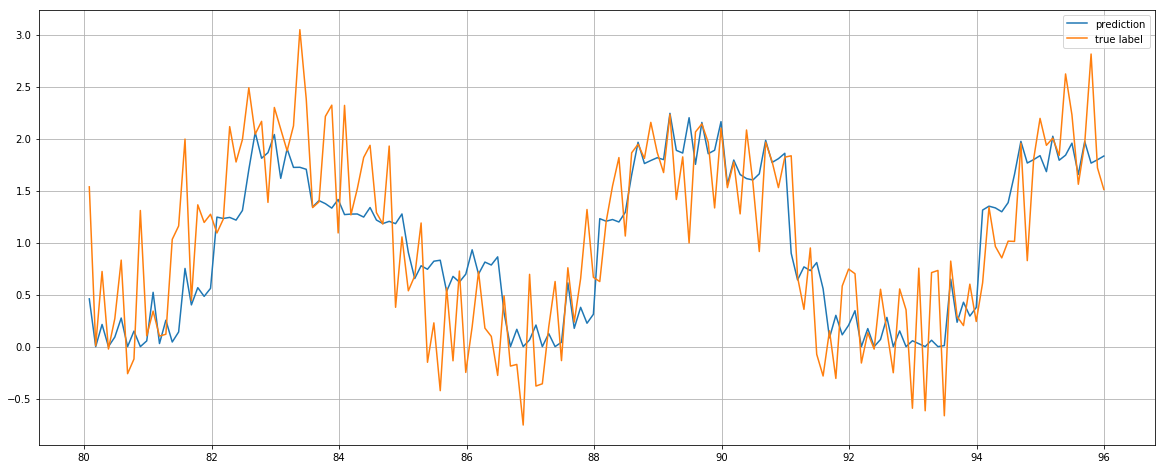

In [14]:
plt.figure(figsize=(20,8))
plt.plot(plot_ctest_x, test_pred, plot_ctest_x, np.roll(ctest_x.reshape(-1), 1))
plt.legend(['prediction', 'true label', 'smoothed'])
plt.grid(True)

#### Generate true prediction instead of relying on true input

In [15]:
%%time
import copy
# loop over each sequence
n_op = 0

# define how many sequences we want to generate
gen_len = 20
assert gen_len < test_y.shape[0], 'sequence to be generated out of range'
test_y1 = copy.deepcopy(test_y[:gen_len])
for i in range(1, gen_len*seq_len):
    print(i, end='\r')
    pred_i = sess.run([pred], feed_dict={X: test_y1})[0]
    # remake the input
    test_y1 = test_y1.reshape(-1)
    test_y1[i] = pred_i.reshape(-1)[i-1]
    test_y1 = test_y1.reshape(-1, seq_len, 1)

test_x1 = test_x[:gen_len*seq_len].reshape(-1)
test_y1 = test_y1.reshape(-1)
true_test_pred = pred_i.reshape(-1)

NameError: name 'test_y' is not defined

In [ ]:
# plt.figure(figsize=(20,8))
# plt.plot(test_x1, true_test_pred, test_x[:-pl], np.roll(test_y,1).reshape(-1), test_x[:-pl], smooth_y_test.reshape(-1)[:-pl])
# plt.legend(['prediction', 'true label', 'smoothed'])